# Evaluate solution to full damped wave equation

This script evalutes an approximative solution to the strongly damped wave equation, with weak form to find $u^n \in V_h$ that solves

$$(u^n, z) + \tau a(u^n, z) + \tau^2 b(u^n, z) = \tau^2 (f,z) + \tau a(u^{n-1}, z) + 2(u^{n-1}, z) - (u^{n-2}, z), \quad \forall z\in V_h,$$

for all $n$. The approximation is evaluated by computing its decomposed parts $v^n\in V^{\text{ms}'}_{H}$ and $w^n\in V^f_h$ and adding them together. For the example, the fine mesh has $1/h=256$ and the coarse mesh is varied such that $1/H = 2,4,...,64$. The error is compared with standard FEM and PG-LOD for the strongly damped wave equation.


In [ ]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from gridlod import util, fem, coef, interp, linalg, pg
from gridlod.world import World
import lod_wave

'''
Settings
'''

# fine mesh parameters
fine = 256
NFine = np.array([fine])
NpFine = np.prod(NFine + 1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine / np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# time step parameters
tau = 0.01
numTimeSteps = 100

# ms coefficients
epsA = 2 ** (-5)
epsB = 2 ** (-5)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

# localization and mesh width parameters
k_0 = np.inf
NList = [2, 4, 8, 16, 32, 64]

error = []
errorFEM = []
errorLod = []

for N in NList:

    # coarse mesh parameters
    NWorldCoarse = np.array([N])
    NCoarseElement = NFine / NWorldCoarse
    world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

    # grid nodes
    xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
    NpCoarse = np.prod(NWorldCoarse + 1)

    '''
    Compute multiscale basis
    '''

    # patch generator and coefficients
    IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                                  NCoarseElement, boundaryConditions)
    b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
    a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

    # compute basis correctors
    lod = lod_wave.LodWave(b_coef, world, k_0, IPatchGenerator, a_coef)
    lod.compute_basis_correctors()

    # compute ms basis
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    basis_correctors = lod.assembleBasisCorrectors()
    ms_basis = basis - basis_correctors

    '''
    Compute finescale system

    fs_solutions[i] = {w^i_x}_x
    '''

    prev_fs_sol = ms_basis
    fs_solutions = []
    for i in xrange(numTimeSteps):
        if i % 10 == 0:
            print 'Calculating correction at N = %d, i = %d' % (N, i)

        # solve non-localized system
        lod = lod_wave.LodWave(b_coef, world, np.inf, IPatchGenerator, a_coef, prev_fs_sol, ms_basis)
        lod.solve_fs_system()

        # store sparse solution
        prev_fs_sol = sparse.csc_matrix(np.array(np.column_stack(lod.fs_list)))
        fs_solutions.append(prev_fs_sol)

    '''
    Compute v^n and w^n
    '''

    # initial value
    Uo = xpCoarse * (1 - xpCoarse)

    # coarse v^(-1) and v^0
    V = [Uo]
    V.append(Uo)

    # fine v^(-1) and v^0
    VFine = [ms_basis * Uo]
    VFine.append(ms_basis * Uo)

    # standard LOD
    Ulod = [Uo]
    Ulod.append(Uo)
    UlodFine = [ms_basis * Uo]
    UlodFine.append(ms_basis * Uo)

    # initial values for standard FEM
    UFEM = [Uo]
    UFEM.append(Uo)
    UFEMFine = [ms_basis * Uo]
    UFEMFine.append(ms_basis * Uo)

    # reference solution
    UFine = [ms_basis * Uo]
    UFine.append(ms_basis * Uo)

    # initial value w^0
    Wo = np.zeros(NpFine)
    WFine = [Wo]

    # compute ms matrices
    S = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, aFine)
    K = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, bFine)
    M = fem.assemblePatchMatrix(NWorldFine, world.MLocFine)

    SmsFull = ms_basis.T * S * ms_basis
    KmsFull = ms_basis.T * K * ms_basis
    MmsFull = ms_basis.T * M * ms_basis

    free = util.interiorpIndexMap(NWorldCoarse)

    SmsFree = SmsFull[free][:, free]
    KmsFree = KmsFull[free][:, free]
    MmsFree = MmsFull[free][:, free]

    boundaryMap = boundaryConditions == 0
    fixedFine = util.boundarypIndexMap(NWorldFine, boundaryMap)
    freeFine = np.setdiff1d(np.arange(NpFine), fixedFine)

    # load vector
    f = np.ones(NpFine)
    LFull = M * f
    LmsFull = ms_basis.T * LFull
    LmsFree = LmsFull[free]

    RmsFreeList = []
    for i in xrange(numTimeSteps):
        n = i + 1

        # linear system
        A = (1. / (tau ** 2)) * MmsFree + (1. / tau) * SmsFree + KmsFree
        b = LmsFree + (1. / tau) * SmsFree * V[n][free] + (2. / (tau ** 2)) * MmsFree * V[n][free] - (1. / (
        tau ** 2)) * MmsFree * V[n - 1][free]

        # store ms matrix R^{ms',h}_{H,i,k}
        RmsFull = ms_basis.T * S * fs_solutions[i]
        RmsFree = RmsFull[free][:, free]
        RmsFreeList.append(RmsFree)

        # add sum to linear system
        if i is not 0:
            for j in range(i):
                b += (1. / tau) * RmsFreeList[j] * V[n - 1 - j][free]

        # solve system
        VFree = linalg.linSolve(A, b)
        VFull = np.zeros(NpCoarse)
        VFull[free] = VFree

        # append solution for current time step
        V.append(VFull)
        VFine.append(ms_basis * VFull)

        # evaluate w^n
        w = 0
        if i is not 0:
            for j in range(0, i + 1):
                w += fs_solutions[j] * V[n - j]
        WFine.append(w)


    '''
    Compute standard LOD solution
    '''

    pglod = pg.PetrovGalerkinLOD(world, k_0, IPatchGenerator, 0)
    pglod.updateCorrectors(b_coef, clearFineQuantities=False)

    pg_basis_correctors = pglod.assembleBasisCorrectors()
    pg_mod_basis = basis - pg_basis_correctors

    SFull = pg_mod_basis.T * S * basis
    KFull = pg_mod_basis.T * K * basis

    SFree = SFull[free][:, free]
    KFree = KFull[free][:, free]

    LFull = basis.T * LFull
    LFree = LFull[free]

    for i in xrange(numTimeSteps):
        n = i + 1

        # standard FEM system
        A = (1. / tau) * SFree + KFree
        b = LFree + (1. / tau) * SFree * Ulod[n][free]

        # solve system
        UlodFree = linalg.linSolve(A, b)
        UlodFull = np.zeros(NpCoarse)
        UlodFull[free] = UlodFree

        # append solution
        Ulod.append(UlodFull)
        UlodFine.append(pg_mod_basis * UlodFull)


    '''
    Compute standard FEM solution
    '''

    # standard FEM matrices
    SFull = basis.T * S * basis
    KFull = basis.T * K * basis
    MFull = basis.T * M * basis

    SFree = SFull[free][:, free]
    KFree = KFull[free][:, free]
    MFree = MFull[free][:, free]

    f = np.ones(NpFine)
    LFull = M * f
    LFull = basis.T * LFull
    LFree = LFull[free]
    for i in xrange(numTimeSteps):

        n = i + 1

        # standard FEM system
        A = (1. / (tau ** 2)) * MFree + (1. / tau) * SFree + KFree
        b = LFree + (1. / tau) * SFree * UFEM[n][free] + (2. / (tau ** 2)) * MFree * UFEM[n][free] - (1. / (
            tau ** 2)) * MFree * UFEM[n - 1][free]

        # solve system
        UFEMFree = linalg.linSolve(A, b)
        UFEMFull = np.zeros(NpCoarse)
        UFEMFull[free] = UFEMFree

        # append solution
        UFEM.append(UFEMFull)
        UFEMFine.append(basis * UFEMFull)

    '''
    Compute reference solution
    '''

    # fine free indices
    boundaryMap = boundaryConditions == 0
    fixedFine = util.boundarypIndexMap(NWorldFine, boundaryMap)
    freeFine = np.setdiff1d(np.arange(NpFine), fixedFine)

    SFree = S[freeFine][:, freeFine]
    KFree = K[freeFine][:, freeFine]
    MFree = M[freeFine][:, freeFine]

    f = np.ones(NpFine)
    LFineFull = M * f
    LFineFree = LFineFull[freeFine]

    for i in range(numTimeSteps):

        n = i + 1

        # reference system
        A = (1. / (tau ** 2)) * MFree + (1. / tau) * SFree + KFree
        b = LFineFree + (1. / tau) * SFree * UFine[n][freeFine] + (2. / (tau ** 2)) * MFree * UFine[n][freeFine] - \
            (1. / (tau ** 2)) * MFree * UFine[n - 1][freeFine]

        # solve system
        UFineFree = linalg.linSolve(A, b)
        UFineFull = np.zeros(NpFine)
        UFineFull[freeFine] = UFineFree

        # append solution
        UFine.append(UFineFull)

    # evaluate L^2-error for time step N
    error.append(np.sqrt(np.dot((UFine[-1] - VFine[-1] - WFine[-1]), (UFine[-1] - VFine[-1] - WFine[-1]))))
    errorFEM.append(np.sqrt(np.dot((UFine[-1] - UFEMFine[-1]), (UFine[-1] - UFEMFine[-1]))))
    errorLod.append(np.sqrt(np.dot((UFine[-1] - UlodFine[-1]), (UFine[-1] - UlodFine[-1]))))


Plot the error $\|u^n - v^n - w^n\|_{L^2}$.


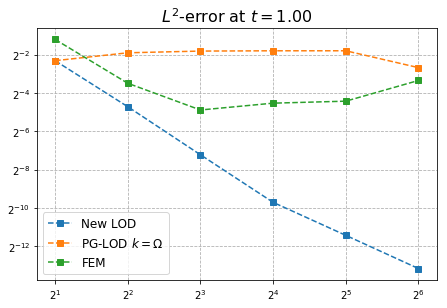

In [2]:
# plot errors
plt.figure('Error comparison')
plt.subplots_adjust(left=0.065, bottom=0.055, right=0.99, top=0.93, wspace=0.1, hspace=0.2)
plt.loglog(NList, error, '--s', basex=2, basey=2, label='New LOD')
plt.loglog(NList, errorLod, '--s', basex=2, basey=2, label='PG-LOD $k=\Omega$')
plt.loglog(NList, errorFEM, '--s', basex=2, basey=2, label='FEM')
plt.grid(True, which="both", ls="--")
plt.title('$L^2$-error at $t=%.2f$' % (numTimeSteps * tau), fontsize=16)
plt.legend(fontsize=12)

plt.show()